<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/api_rnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [66]:
import scipy
from keras.models import Model, Sequential
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Embedding
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam
from keras.models import load_model, save_model

import datetime
import sys
import os
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.python.keras.backend import set_session, clear_session
# tf.compat.v1.disable_v2_behavior()

import time

from tqdm import tqdm

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2

import requests
import base64
from io import BytesIO

import json

In [3]:
# from https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py

from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K


class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
project_path = '/content/drive/My Drive/hairy_gan'

enc = load_model(os.path.join(project_path, 'glasses_only', 'enc.h5'), custom_objects={'InstanceNormalization': InstanceNormalization})
dec = load_model(os.path.join(project_path, 'glasses_only', 'dec.h5'), custom_objects={'InstanceNormalization': InstanceNormalization})

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
def load_imgs(img_paths, preprocess=True):
  imgs = []
  img_props = []

  for img_path in img_paths:

    if isinstance(img_path, str):
      img = plt.imread(img_path) * 255.
      img = img[:, :, :3]
    else:
      img = img_path

    img_props.append(img.shape)

    if preprocess:
      img = cv2.resize(img, img_res)
      img = img / 127.5 - 1.
    imgs.append(img)

  imgs = np.array(imgs)
  return imgs, img_props

In [6]:
def get_predictions(imgs, attrs):
  imgs = np.array(imgs)
  attrs = np.array(attrs)
  encodings = enc.predict(imgs)
  predictions = dec.predict([encodings, attrs])
  return predictions

In [7]:
def post_process_imgs(imgs, img_props):
  imgs = np.array([cv2.resize(img, (img_prop[1], img_prop[0])) for img, img_prop in zip(imgs, img_props)])
  return (imgs + 1.) * 127.5

In [8]:
# model requirements
img_res = enc.input_shape[1:-1]
attr_size = 1

# website link
website_link = 'https://hairygan--garlandzhang.repl.co'

In [9]:
IMGUR_URL = 'https://api.imgur.com/3/'
CLIENT_ID = '853e92d46b2081a'
CLIENT_SECRET = '5c77e3cad7f64553ce00913309896c4482ed0c79'
RAGIC_ID = 'WGhod3FVU0lmNHNjaXVyTmpXbUJhVjlKMUNxTGVZM2JJejk2K2FHRW5XT3I2dXB5bXY0UythaWVQbUd6MXUrS293TjZKT1VBYStBPQ=='
DB_URL = 'https://na3.ragic.com/weewoowarrior/hairygan/2?v=3&api'

In [10]:
while True:
  # user inputs
  attrs = [[1]] # give this person glasses

  # user img
  img_paths = [] # also acts as array for imgs
  while True:
    db_data_retrieval_res = requests.get(
        url=DB_URL,
        headers={
          'Authorization': 'Basic ' + RAGIC_ID
        }
    )

    retrieved_data = json.loads(db_data_retrieval_res.content)

    entries = list(retrieved_data.items())
    entries.sort()

    if int(entries[-1][1]['processed']) == 0:
      time.sleep(1)
      entry_id = entries[-1][0]
      img_url = entries[-1][1]['original_image_url'] # get last entry, value, image url (most recent)
      img_paths = [img_url]
      break

    print('All processed')
    time.sleep(1)

  start_time = time.time()
  imgs, img_props = load_imgs(img_paths, preprocess=True) # in truth we only deal with one image...
  orig_imgs, _ = load_imgs(img_paths, preprocess=False)
  predictions = get_predictions(imgs, attrs)
  pred_imgs = post_process_imgs(predictions, img_props)
  end_time = time.time()
  time_diff = end_time - start_time


  img_enc = base64.b64encode(pred_imgs[0].astype(np.uint8))
  img_prop_enc = base64.b64encode(np.array(img_props[0][:-1], dtype=np.uint8))
  x = requests.post(os.path.join(website_link, 'predictions'), data={'predictions': img_enc, 'img_props': img_prop_enc })

  img = cv2.cvtColor(pred_imgs[0].astype(np.uint8), cv2.COLOR_BGR2RGB)
  cv2.imwrite('img.jpg', img) # use local save as hack
  img_bytes = open('img.jpg', 'rb').read()

  # upload to img db
  print('Upload to image database')

  res = requests.post(
    url= IMGUR_URL + 'upload.json',
    data={
        'image': base64.b64encode(img_bytes),
        'type': 'base64',
    },
    headers={
        'Authorization': 'Client-ID ' + CLIENT_IDI,
    }
  )

  data = json.loads(res.content.decode("utf-8"))['data']
  print(data)

  # update database
  print('Update database')

  res = requests.post(
    url=f'https://na3.ragic.com/weewoowarrior/hairygan/2/{entry_id}?v=3&api', 
    params={
        '1000017': data['link'],
        '1000018': 1,
    },
    headers={
        'Authorization': 'Basic ' + RAGIC_ID
    }
  )

  time.sleep(1)
  print('Done')


All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed
All processed


KeyboardInterrupt: ignored

In [11]:
seg_model = load_model(os.path.join(project_path, 'g_IS.h5'), custom_objects={'InstanceNormalization': InstanceNormalization})

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
imgs, img_props = load_imgs([os.path.join(project_path, 'test_img.jpg')], preprocess=False)
imgs = np.array([cv2.resize(img, img_res) for img in imgs]) / 255.

In [50]:
masks = seg_model.predict(imgs) * 255.

In [51]:
cv2.imwrite('img.jpg', preds[0])

True

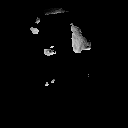

In [65]:
# apply seg mask
img = imgs[0]

MASK_THRESH = 128
mask = masks[0]
mask[mask < MASK_THRESH] = 0
mask[mask > MASK_THRESH] = 255
mask = mask.astype(np.uint8)

img_with_mask = cv2.bitwise_and(img, img, mask=mask)
Image.fromarray(img_with_mask.astype(np.uint8))

In [67]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [106]:
style_image = np.zeros(shape=(1, ) + img_res + (3, )).astype(np.float32)
style_image[:, :, :, 1] = 255
style_tensor = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')

In [137]:
content_image = img.astype(np.float32)
content_image = tf.expand_dims(img, axis=0)
content_image = tf.image.convert_image_dtype(content_image, dtype=tf.float32)

In [138]:
outputs = hub_module(content_image, style_tensor)
stylized_image = outputs[0]

In [135]:
def display(images):
  rows, cols = len(images[0]), len(images)
  fig, axes = plt.subplots(rows, cols)

  count = 0

  if rows == 1:
    for col in range(cols):
      axes[col].imshow(images[count][0])
      axes[col].axis('off')
      count += 1
  else:
    for row in range(rows):
      for col in range(cols):
        axes[row, col].imshow(images[row][count])
        axes[row, col].axis('off')
        count += 1

  plt.show()

In [151]:
mask_3ch = np.zeros((1, ) + img_res + (3, ))
mask_3ch[:] = mask
mask_3ch = tf.Variable(mask_3ch)

In [176]:
stylized_image_np = (stylized_image.numpy() * 255.).astype(np.uint8)[0]
stylized_img_with_mask = cv2.bitwise_and(stylized_image_np, stylized_image_np, mask=mask)
stylized_img_with_mask = np.expand_dims(stylized_img_with_mask, axis=0)

In [194]:
content_image_np = content_image.numpy()
stylized_hair_img = content_image_np.copy()
stylized_hair_img[stylized_img_with_mask > 0] = 0
stylized_hair_img_with_mask = stylized_hair_img + stylized_img_with_mask

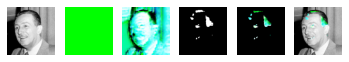

In [196]:
display([content_image / 255., style_image, stylized_image, mask_3ch, stylized_img_with_mask, stylized_hair_img_with_mask / 255.])